The different simulation methods(CME, ODE, SSA, T-leaping) for the reaction A---->B


<h3>Simulate CME using ODE</h3>

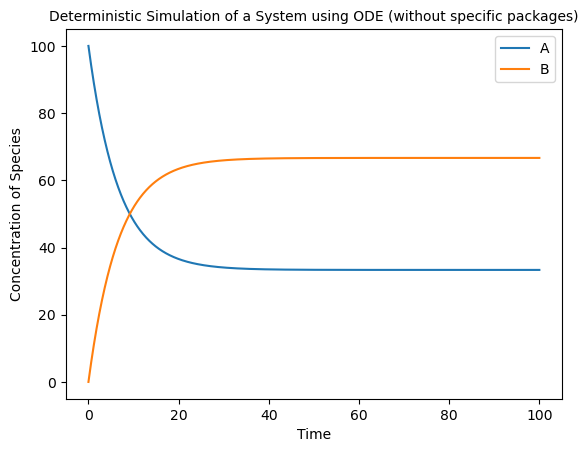

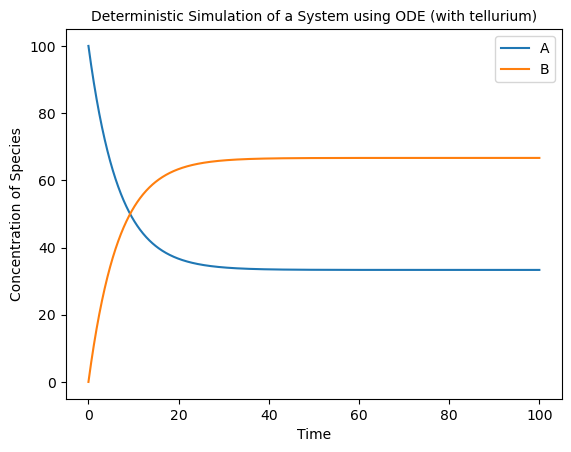

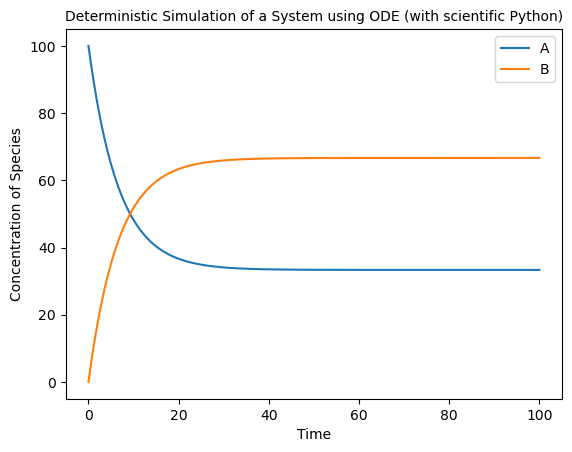

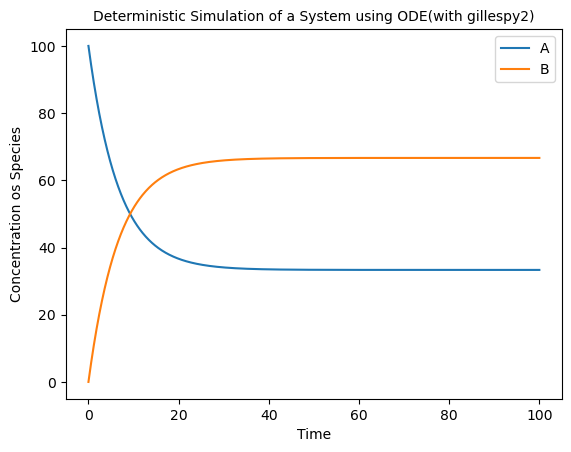

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import tellurium as te
import gillespy2

# Simulate with ODE
# System variables
k1 = 0.1
k2 = 0.05
A_0 = 100
B_0 = 0
t_0 = 0
t_end = 100
num_steps = 1000

# System steps
time = np.linspace(t_0, t_end, num_steps)
A_conc = np.zeros(num_steps)
B_conc = np.zeros(num_steps)

# Initialize the system
A_conc[0] = A_0
B_conc[0] = B_0

# Simulate the system
for i in range(1, num_steps):
    Rate_A = k2 * B_conc[i-1] - k1 * A_conc[i-1]
    Rate_B = k1 * A_conc[i-1] - k2 * B_conc[i-1]
    A_conc[i] = A_conc[i-1] + Rate_A * (time[i] - time[i-1])
    B_conc[i] = B_conc[i-1] + Rate_B * (time[i] - time[i-1])
    

plt.plot(time, A_conc, label = 'A')
plt.plot(time, B_conc, label = 'B')
plt.xlabel('Time', fontsize=10)
plt.ylabel('Concentration of Species', fontsize=10)
plt.title('Deterministic Simulation of a System using ODE (without specific packages)', fontsize=10)
plt.legend()
plt.show()


#Simulate with Tellurium
model= te.loada('''
     k1=0.1; k2=0.05; A=100; B=0;
     A -> B; k1*A;
     B -> A; k2*B;
''')

model.reset()
results = model.simulate(0,100,1000)

A_conc = results[:, 1]
B_conc = results[:, 2]
time = results[:, 0]


plt.plot(time,A_conc, label='A')
plt.plot(time,B_conc, label='B')
plt.xlabel('Time', fontsize=10)
plt.ylabel('Concentration of Species', fontsize=10)
plt.title('Deterministic Simulation of a System using ODE (with tellurium)', fontsize=10)
plt.legend()
plt.show()


# Simulate with scipy

def reaction_system(y, t):
    A, B = y
    dAdt = -k1 * A + k2 * B
    dBdt = k1 * A - k2 * B
    return [dAdt, dBdt]

# Initialize the system
y0 = [A_0, B_0]


t = np.linspace(t_0, t_end, num_steps)  
result = odeint(reaction_system, y0, t)
pop_A = result[:, 0]
pop_B = result[:, 1]

plt.plot(t, pop_A, label='A')
plt.plot(t, pop_B, label='B')
plt.xlabel('Time', fontsize=10)
plt.ylabel('Concentration of Species', fontsize=10)
plt.title('Deterministic Simulation of a System using ODE (with scientific Python)', fontsize=10)
plt.legend()
plt.show()

# usiage of Gillespy2
def my_model(parameter_values=None):
    # First call the gillespy2.Model initializer.
    model = gillespy2.Model(name='reversible reaction')

    # Define parameters for the rates of creation and dissociation.
    k_1 = gillespy2.Parameter(name='k_1', expression=0.1)
    k_2 = gillespy2.Parameter(name='k_2', expression=0.05)
    model.add_parameter([k_1, k_2])

    # Define variables for the molecular species representing M and D.
    m = gillespy2.Species(name='reactant', initial_value=100)
    d = gillespy2.Species(name='product',   initial_value=0)
    model.add_species([m, d])

    # The list of reactants and products for a Reaction object are each a
    # Python dictionary in which the dictionary keys are Species objects
    # and the values are stoichiometries of the species in the reaction.
    r_1 = gillespy2.Reaction(name="r_forward", rate=k_1, reactants={m:1}, products={d:1})
    r_2 = gillespy2.Reaction(name="r_backward", rate=k_2, reactants={d:1}, products={m:1})
    model.add_reaction([r_1, r_2])

    # Set the timespan for the simulation.
    tspan = gillespy2.TimeSpan.linspace(t=100, num_points=1001)
    model.timespan(tspan)
    return model
model = my_model()
# the run() function without any input results in a SSA simulation
#Hte methods used in algorithm are 'SSA', 'ODE', 'CLE', 'Tau-Leaping', or 'Tau-Hybrid'
results = model.run(algorithm='ODE') 

p = results['product']
t = results['time']
r = results['reactant']
plt.plot(t, r, label='A')
plt.plot(t, p, label='B')
plt.title('Deterministic Simulation of a System using ODE(with gillespy2)', fontsize=10)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Concentration os Species', fontsize=10)
plt.legend()
plt.show()


    

<h3>Simulate CME using SSA Method</h3>
<h4> SSA Steps </h4>

1. Initialize the time, populations, and reaction rates:
   - Set the initial time to 0.
   - Set the initial population of A to a given value.
   - Set the initial population of B to 0.
   - Set the reaction rates `k1` and `k2` to the given values.
2. Initialize the reaction counter:
   - Set the reaction count to 0.
3. While the simulation time is less than the desired end time:
   - Calculate the propensity functions for each reaction:
     - Propensity function for A -> B: `a1 = k1 * A`
     - Propensity function for B -> B: `a2 = k2 * B`
     (where `A` and `B` are the current populations of A and B, respectively)
4. Calculate the total propensity (`atot = a1 + a2`).
5. Generate two random numbers:
   - `r1`: Uniformly distributed random number between 0 and 1.
   - `r2`: Uniformly distributed random number between 0 and 1.
6. Calculate the time increment (`dt`) using the formula: `dt = (1 / atot) * ln(1 / r1)`.
7. Update the simulation time: `time = time + dt`.
8. Determine which reaction occurs:
   - If `r2 * atot <= a1`, reaction A -> B occurs:
     - Increment the reaction counter: `reaction_count = reaction_count + 1`.
     - Update the populations: `A = A - 1` and `B = B + 1`.
   - Otherwise, reaction B -> B occurs:
     - Increment the reaction counter: `reaction_count = reaction_count + 1`.
9. Store the updated populations and time in arrays or data structures for later analysis.

10. Repeat steps 3-9 until the simulation time reaches the desired end time.

   

    




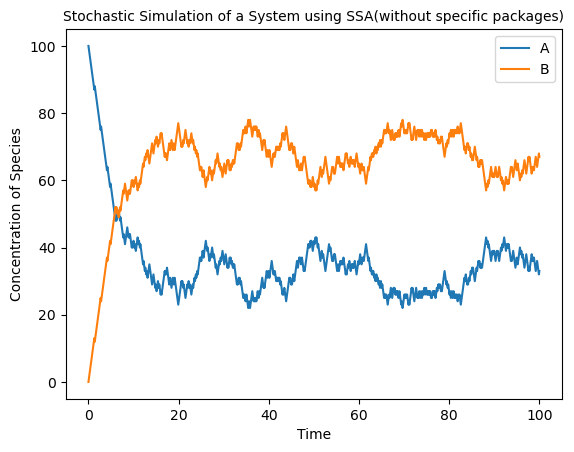

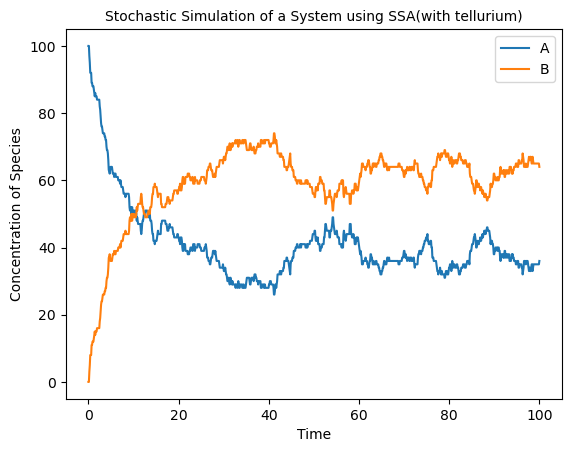

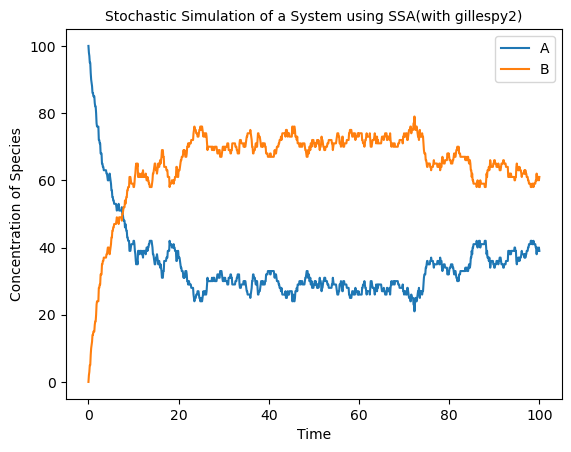

'\nrun(model, t=20, number_of_trajectories=1, increment=0.05, seed=None, debug=False, profile=False, **kwargs)[source]\nCall out and run the solver. Collect the results.\n\nParameters:\nmodel (gillespy.Model) – The model on which the solver will operate.\n\nt (int) – The end time of the solver\n\nnumber_of_trajectories (int) – The number of times to sample the chemical master equation. Each trajectory will be returned at the end of the simulation.\n\nincrement (float) – The time step of the solution\n\nseed (int) – The random seed for the simulation. Defaults to None.\n\ndebug (bool) – Set to True to provide additional debug information about the simulation.\n'

In [7]:
import tellurium as te
import numpy as np
import matplotlib.pyplot as plt
import gillespy2
from scipy.integrate import odeint
# the parameters of the simulation
k1 = 0.1
k2 = 0.05
A_0 = 100
B_0 = 0
t_0 = 0
t_end = 100
num_steps = 1000

# system steps(each array contains 1000 steps)
time = np.linspace(t_0, t_end, num_steps)
A_conc = np.zeros(num_steps)
B_conc = np.zeros(num_steps)

# initialize the system
A_conc[0] = A_0
B_conc[0] = B_0

for i in range(1, num_steps):
    propensities = np.array([k1 * A_conc[i-1], k2 * B_conc[i-1]])# calculate aj(x)
    
    total_propensities = np.sum(propensities) # calculate asum(x) 
    
    r_num1 = np.random.rand()# this random number is tau, which used to calculate time interval(dt) between reactions
    r_num2 = np.random.rand()# this random number is used to calculate the occurance of the next reaction,
    
    
    dt = (1/total_propensities) * np.log(1/r_num1) # calculate the time interval
    #based on asum(total_propensities) and r_num1.
    
    reaction = np.argmax(r_num2 * total_propensities <= np.cumsum(propensities)) # this function determines
    # which reaction as next reaction occures, in this falls there is only two possibilities(1.A-->B, 2.B-->A)
    
    # Update populations
    if reaction == 0: # it means the reaction (A--->B) occures
        A_conc[i] = A_conc[i-1] - 1
        B_conc[i] = B_conc[i-1] + 1
    elif reaction == 1: # it means the reverse (B--->A) reaction occures
        A_conc[i] = A_conc[i-1] + 1
        B_conc[i] = B_conc[i-1] - 1

plt.plot(time, A_conc, label='A')
plt.plot(time, B_conc, label='B')
plt.title('Stochastic Simulation of a System using SSA(without specific packages)', fontsize=10)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Concentration of Species', fontsize=10)
plt.legend()
plt.show()  


# Define the model
model= te.loada('''
     k1=0.1; k2=0.05; A=100; B=0;
     A -> B; k1*A;
     B -> A; k2*B;
''')

model.reset()
model.integrator = 'gillespie'

# Simulate the model
results = model.simulate(t_0, t_end, num_steps)

# Extract the time and concentration data
time = results[:, 0]
A_conc = results[:, 1]
B_conc = results[:, 2]


plt.plot(time, A_conc, label='A')
plt.plot(time, B_conc, label='B')
plt.title('Stochastic Simulation of a System using SSA(with tellurium)', fontsize=10)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Concentration of Species', fontsize=10)
plt.legend()
plt.show()

#SSA using Gillespy2

def my_model(parameter_values=None):
    # First call the gillespy2.Model initializer.
    model = gillespy2.Model(name='reversible reaction')

    # Define parameters for the rates of creation and dissociation.
    k_1 = gillespy2.Parameter(name='k_1', expression=0.11)
    k_2 = gillespy2.Parameter(name='k_2', expression=0.05)
    model.add_parameter([k_1, k_2])

    # Define variables for the molecular species representing M and D.
    m = gillespy2.Species(name='reactant', initial_value=100)
    d = gillespy2.Species(name='product',   initial_value=0)
    model.add_species([m, d])

    # The list of reactants and products for a Reaction object are each a
    # Python dictionary in which the dictionary keys are Species objects
    # and the values are stoichiometries of the species in the reaction.
    r_1 = gillespy2.Reaction(name="r_forward", rate=k_1, reactants={m:1}, products={d:1})
    r_2 = gillespy2.Reaction(name="r_backward", rate=k_2, reactants={d:1}, products={m:1})
    model.add_reaction([r_1, r_2])

    # Set the timespan for the simulation.
    tspan = gillespy2.TimeSpan.linspace(t=100, num_points=1001)
    model.timespan(tspan)
    return model
model = my_model()
# the run() function without any input results in a SSA simulation
#Hte methods used in algorithm are 'SSA', 'ODE', 'CLE', 'Tau-Leaping', or 'Tau-Hybrid'
results = model.run(algorithm='SSA') 

p = results['product']
t = results['time']
r = results['reactant']
plt.plot(t, r, label='A')
plt.plot(t, p, label='B')
plt.title('Stochastic Simulation of a System using SSA(with gillespy2)', fontsize=10)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Concentration of Species', fontsize=10)
plt.legend()
plt.show()



"""
run(model, t=20, number_of_trajectories=1, increment=0.05, seed=None, debug=False, profile=False, **kwargs)[source]
Call out and run the solver. Collect the results.

Parameters:
model (gillespy.Model) – The model on which the solver will operate.

t (int) – The end time of the solver

number_of_trajectories (int) – The number of times to sample the chemical master equation. Each trajectory will be returned at the end of the simulation.

increment (float) – The time step of the solution

seed (int) – The random seed for the simulation. Defaults to None.

debug (bool) – Set to True to provide additional debug information about the simulation.
"""

<h3>Simulate CME using T-Leaping Method</h3>

A Tau Leaping solver for GillesPy2 models. This solver uses an algorithm that calculates multiple reactions in a single step over a given tau step size. The change in propensities over this step are bounded by bounding the relative change in state, yielding greatly improved run-time performance with very little trade-off in accuracy.

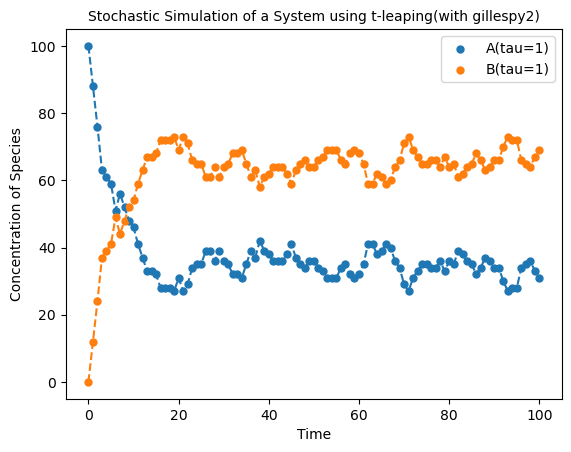

In [13]:
import numpy as np
from scipy.integrate import odeint
import tellurium as te
import matplotlib.pyplot as plt
import seaborn as sns
import gillespy2


k1 = 1
k2 = 0.5
A_0 = 100
B_0 = 0
t_0 = 0
t_end = 100
num_steps = 1000
def my_model(parameter_values=None):
   
    model = gillespy2.Model(name='reversible reaction')

    k_1 = gillespy2.Parameter(name='k_1', expression=0.1)
    k_2 = gillespy2.Parameter(name='k_2', expression=0.05)
    model.add_parameter([k_1, k_2])

    m = gillespy2.Species(name='reactant', initial_value=100)
    d = gillespy2.Species(name='product',   initial_value=0)
    model.add_species([m, d])

    r_1 = gillespy2.Reaction(name="r_forward", rate=k_1, reactants={m:1}, products={d:1})
    r_2 = gillespy2.Reaction(name="r_backward", rate=k_2, reactants={d:1}, products={m:1})
    model.add_reaction([r_1, r_2])

    tspan = gillespy2.TimeSpan.linspace(t=100, num_points=101)
    model.timespan(tspan)
    return model
model = my_model()

results = model.run(algorithm='Tau-Leaping') 

p = results['product']
t = results['time']
r = results['reactant']

plt.scatter(t, r, s=25, label='A(tau=1)')
plt.scatter(t, p, s=25, label='B(tau=1)')
plt.plot(t, r, linestyle='dashed')
plt.plot(t, p, linestyle='dashed')
plt.title('Stochastic Simulation of a System using t-leaping(with gillespy2)', fontsize=10)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Concentration of Species', fontsize=10)
plt.legend()
plt.show()


<h3>Simulate CME using CLE</h3>

A Chemical Langevin Equation Solver for GillesPy2 models.

This solver uses an algorithm that calculates multiple reactions in a single step over a given tau step size. The change in propensities over this step are bounded by bounding the relative change in state, yielding greatly improved run-time performance with very little trade-off in accuracy.

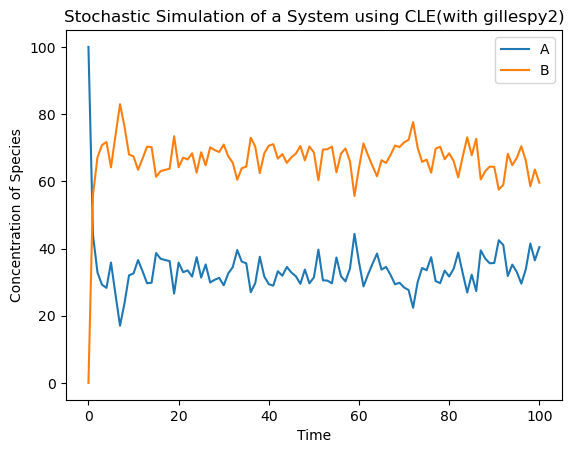

In [35]:
import numpy as np
from scipy.integrate import odeint
import tellurium as te
import matplotlib.pyplot as plt
import gillespy2


k1 = 1
k2 = 0.5
A_0 = 100
B_0 = 0
t_0 = 0
t_end = 100
num_steps = 1000
def my_model(parameter_values=None):
   
    model = gillespy2.Model(name='reversible reaction')

    k_1 = gillespy2.Parameter(name='k_1', expression=0.1)
    k_2 = gillespy2.Parameter(name='k_2', expression=0.05)
    model.add_parameter([k_1, k_2])

    m = gillespy2.Species(name='reactant', initial_value=100)
    d = gillespy2.Species(name='product',   initial_value=0)
    model.add_species([m, d])

    r_1 = gillespy2.Reaction(name="r_forward", rate=k_1, reactants={m:1}, products={d:1})
    r_2 = gillespy2.Reaction(name="r_backward", rate=k_2, reactants={d:1}, products={m:1})
    model.add_reaction([r_1, r_2])

    tspan = gillespy2.TimeSpan.linspace(t=100, num_points=101)
    model.timespan(tspan)
    return model
model = my_model()

results = model.run(algorithm='CLE') 

p = results['product']
t = results['time']
r = results['reactant']
plt.plot(t, r, label='A')
plt.plot(t, p, label='B')
plt.title('Stochastic Simulation of a System using CLE(with gillespy2)')
plt.xlabel('Time')
plt.ylabel('Concentration of Species')
plt.legend()
plt.show()


<h3>Simulate CME using Tau-Hybrid</h3>

This solver uses a root-finding interpretation of the direct SSA method, along with ODE solvers to simulate ODE and Stochastic systems interchangeably or simultaneously. Uses integrators from scipy.integrate.ode to perform calculations used to produce solutions.

GillesPy2 offers many alternative methods for solving the system of equations defined by a model. This example demonstrates the use of GillesPy2’s Hybrid Switching solver. It is designed to switch automatically and dynamically between continuous and stochastic representations of the molecular species in a model. This hybrid solver represents a species deterministically when it has a high population (thus executing the simulation more efficiently), and automatically switches to a stochastic representation at lower populations (for greater accuracy at low numbers). The result is an overall improved run-time over solely stochastic simulation.

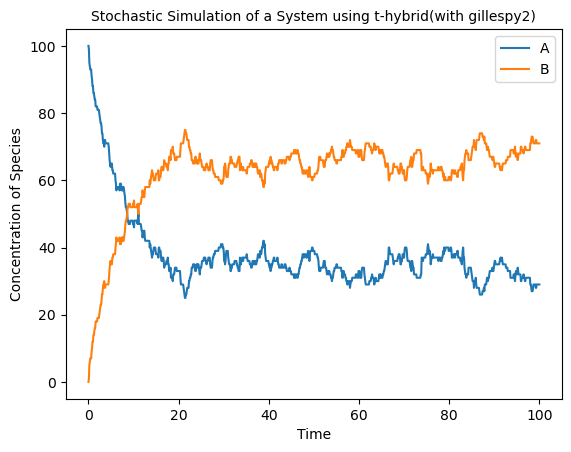

In [18]:
import numpy as np
from scipy.integrate import odeint
import tellurium as te
import matplotlib.pyplot as plt
import gillespy2


k1 = 1
k2 = 0.5
A_0 = 100
B_0 = 0
t_0 = 0
t_end = 100
num_steps = 1000
def my_model(parameter_values=None):
   
    model = gillespy2.Model(name='reversible reaction')

    k_1 = gillespy2.Parameter(name='k_1', expression=0.1)
    k_2 = gillespy2.Parameter(name='k_2', expression=0.05)
    model.add_parameter([k_1, k_2])

    m = gillespy2.Species(name='reactant', initial_value=100)
    d = gillespy2.Species(name='product',   initial_value=0)
    model.add_species([m, d])

    r_1 = gillespy2.Reaction(name="r_forward", rate=k_1, reactants={m:1}, products={d:1})
    r_2 = gillespy2.Reaction(name="r_backward", rate=k_2, reactants={d:1}, products={m:1})
    model.add_reaction([r_1, r_2])

    tspan = gillespy2.TimeSpan.linspace(t=100, num_points=1001)
    model.timespan(tspan)
    return model
model = my_model()

results = model.run(algorithm='Tau-Hybrid') 

p = results['product']
t = results['time']
r = results['reactant']
plt.plot(t, r, label='A')
plt.plot(t, p, label='B')
plt.title('Stochastic Simulation of a System using t-hybrid(with gillespy2)', fontsize=10)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Concentration of Species', fontsize=10)
plt.legend()
plt.show()




In [1]:
import gillespy2 as g
import numpy as np
import matplotlib.pyplot as plt


def reaction_system(X_0, algorithm, num_steps):
    
    model = g.Model(name='reaction_network')
    
    k1 = g.Parameter(name='k1', expression=0.0000003)
    k2 = g.Parameter(name='k2', expression=0.0001)
    k3 = g.Parameter(name='k3', expression=0.001)
    k4 = g.Parameter(name='k4', expression=3.50)
    
    A = g.Species(name='A', initial_value=100000)
    B = g.Species(name='B', initial_value=200000)
    X = g.Species(name='X', initial_value=X_0)

    propensity_r1 = "k1 * A * X * (X - 1) / 2"
    propensity_r2 = "k2 * X * (X - 1) * (X - 2) / 6"

    r1 = g.Reaction(name='r1', propensity_function=propensity_r1, reactants={A:1, X:2}, products={X:3})
    r2 = g.Reaction(name='r2', propensity_function=propensity_r2, reactants={X:3}, products={A:1, X:2})
    r3 = g.Reaction(name='r3', rate=k3, reactants={B:1}, products={X:1})
    r4 = g.Reaction(name='r4', rate=k4, reactants={X:1}, products={B:1})

    model.add_parameter([k1, k2, k3, k4])
    model.add_species([A, B, X])
    model.add_reaction([r1, r2, r3, r4])

    tspan = g.TimeSpan.linspace(t=10, num_points=num_steps)
    model.timespan(tspan)
    result = model.run(algorithm=algorithm)

    x_conc = result['X']
    time = result['time']
    if algorithm == 'Tau-Leaping' or algorithm == 'CLE':
        
        plt.scatter(time, x_conc, s=15, color='red')
        plt.plot(time, x_conc, color='red', linestyle='dashed', label=algorithm)
        plt.legend()
    else:
        
        plt.plot(time, x_conc, color='blue', label=algorithm)
        plt.legend()
        
    return plt.show()

reaction_system(400, 'ODE', 1000)



SimulationError: argument 'solver=<gillespy2.solvers.cpp.ode_c_solver.ODECSolver object at 0x000002AD65A72DA0>' to run() failed.  Reason Given: Error encountered while running simulation C++ file (return code: 3221225785)